[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.

But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools.

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GEMINI_API_KEY")

GEMINI_API_KEY: ··········


Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [3]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

LANGCHAIN_API_KEY: ··········


**Note:** Obtain the necessary json key from the Google Cloud Console by following the instructions outlined in step 21_langchain_ecosystem/langchain/-01_gemini_standalone/Gemini_API_python.ipynb file. Once acquired, load the json key in Google Colab to proceed with the project.

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/<your-json-key-here>"

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key =  os.environ["GEMINI_API_KEY"])
llm_with_tools = llm.bind_tools(tools)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState) -> MessagesState:
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

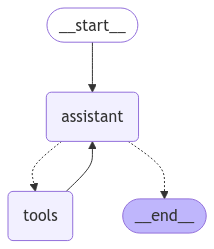

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [8]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (18accea7-24f2-4fa2-bb19-e9081c5c1f29)
 Call ID: 18accea7-24f2-4fa2-bb19-e9081c5c1f29
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (885da731-59c7-4789-a945-a247b0064812)
 Call ID: 885da731-59c7-4789-a945-a247b0064812
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (64c47413-a260-4e77-8999-3a483e8c21f7)
 Call ID: 64c47413-a260-4e77-8999-3a483e8c21f7
  Args:
    a: 14.0
    b: 5.0
========

**Note:** In above error the problem is that multiple chained operations ("add", "multiply", and "divide") are being interpreted incorrectly, likely leading to premature calls to tools without resolving earlier steps as model is following <b>DMAS</b> rule here. So we will improved the prompt and try again

In [9]:
messages = [HumanMessage(content="First Add 3 and 4 then multiply answer with 2 and then divide answer with 5. Dont perform division initially")]
messages = react_graph.invoke({"messages": messages})

In [10]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

First Add 3 and 4 then multiply answer with 2 and then divide answer with 5. Dont perform division initially
================================== Ai Message ==================================
Tool Calls:
  add (7c72d00a-4a34-47cc-9885-ffeb25171875)
 Call ID: 7c72d00a-4a34-47cc-9885-ffeb25171875
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (67fb2ae7-e8b4-4d24-ba30-9dec3439577a)
 Call ID: 67fb2ae7-e8b4-4d24-ba30-9dec3439577a
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (2b679758-2162-4335-8cf2-22ae312d2445)
 Call ID: 2b679758-2162-4335-8cf2-22ae3

In [13]:
messages = [HumanMessage(content="Hello")]
messages = react_graph.invoke({"messages": messages})
messages

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='11badd38-fcc3-43b7-abf6-1f2b668b6cd7'),
  AIMessage(content='Hello! How may I help you?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-bd9191fb-6996-49be-88c8-37300a8d1739-0', usage_metadata={'input_tokens': 161, 'output_tokens': 9, 'total_tokens': 170, 'input_token_details': {'cache_read': 0}})]}

In [14]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How may I help you?


## LangSmith

We can look at traces in LangSmith.